# Plant_Leaf_Classification

## 1. 개요
- 9개 식물(사과, 체리, 옥수수, 포도, 복숭아, 후추, 감자, 딸기, 토마토) 잎의 질병 데이터를 활용하여 질병을 판별하는 모델을 만든다
- 각 데이터의 질병들, 정상 데이터가 분류되어 있다
- 데이터 밸런스는 불균형하다

## 2. 데이터 준비

### 데이터 가져오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq "/content/drive/MyDrive/data/Plant_Leaf_Classification_dataset.zip" -d "./dataset"

### 데이터 정리 및 현황 확인

In [3]:
import os

original_dataset_dir = "./dataset"
classes_list = os.listdir(original_dataset_dir)

base_dir = "./splitted"
os.mkdir(base_dir)

In [4]:
import shutil

train_dir = os.path.join(base_dir, "train")
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, "val")
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, "test")
os.mkdir(test_dir)

for cls in classes_list:
  os.mkdir(os.path.join(train_dir, cls))
  os.mkdir(os.path.join(validation_dir, cls))
  os.mkdir(os.path.join(test_dir, cls))

In [5]:
import math

for cls in classes_list:
  path = os.path.join(original_dataset_dir, cls)
  fnames = os.listdir(path)

  train_size = math.floor(len(fnames) * 0.6)
  validation_size = math.floor(len(fnames) * 0.2)
  test_size = math.floor(len(fnames) * 0.2)

  train_fnames = fnames[:train_size]
  print("Train size(",cls,"): ", len(train_fnames))
  for fname in train_fnames:
    src = os.path.join(path, fname)
    dst = os.path.join(os.path.join(train_dir, cls), fname)
    shutil.copyfile(src, dst)

  validation_fnames = fnames[train_size:(validation_size + train_size)]
  print("Validation size(",cls,"): ", len(validation_fnames))
  for fname in validation_fnames:
    src = os.path.join(path, fname)
    dst = os.path.join(os.path.join(validation_dir, cls), fname)
    shutil.copyfile(src, dst)

  test_fnames = fnames[(validation_size + train_size):(validation_size + train_size + test_size)]
  print("Test size(",cls,"): ", len(test_fnames))
  for fname in test_fnames:
    src = os.path.join(path, fname)
    dst = os.path.join(os.path.join(test_dir, cls), fname)
    shutil.copyfile(src, dst)

Train size( Grape___healthy ):  253
Validation size( Grape___healthy ):  84
Test size( Grape___healthy ):  84
Train size( Tomato___Target_Spot ):  842
Validation size( Tomato___Target_Spot ):  280
Test size( Tomato___Target_Spot ):  280
Train size( Apple___Cedar_apple_rust ):  165
Validation size( Apple___Cedar_apple_rust ):  55
Test size( Apple___Cedar_apple_rust ):  55
Train size( Potato___Early_blight ):  600
Validation size( Potato___Early_blight ):  200
Test size( Potato___Early_blight ):  200
Train size( Corn___Common_rust ):  715
Validation size( Corn___Common_rust ):  238
Test size( Corn___Common_rust ):  238
Train size( Tomato___Tomato_Yellow_Leaf_Curl_Virus ):  3214
Validation size( Tomato___Tomato_Yellow_Leaf_Curl_Virus ):  1071
Test size( Tomato___Tomato_Yellow_Leaf_Curl_Virus ):  1071
Train size( Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ):  645
Validation size( Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ):  215
Test size( Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ):  21

## 3. 데이터 전처리

In [7]:
import torch
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
EPOCH = 30
print("The Device is", DEVICE)

The Device is cuda


In [8]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])
train_dataset = ImageFolder(root="./splitted/train", transform=transform_base)
val_dataset = ImageFolder(root="./splitted/val", transform=transform_base)

In [20]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=4)

## 4. 모델링

In [21]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
  
  def __init__(self):
    
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 64, 3, padding=1)

    self.fc1 = nn.Linear(4096, 512)
    self.fc2 = nn.Linear(512, 33)

  def forward(self, x):

    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = F.dropout(x, p=0.25, training=self.training)  # 훈련할 떄만 dropout
    
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = F.dropout(x, p=0.25, training=self.training)

    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool(x)
    x = F.dropout(x, p=0.25, training=self.training)

    x = x.view(-1, 4096)
    x = self.fc1(x)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.fc2(x)

    return F.log_softmax(x, dim=1)


In [22]:
model_base = Net().to(DEVICE)
optimizer = optim.Adam(model_base.parameters(), lr=0.001)

## 5. 모델 학습 및 평가

In [23]:
def train(model, train_loader, optimizer):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(DEVICE), target.to(DEVICE)
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(DEVICE), target.to(DEVICE)
      output = model(data)

      test_loss += F.cross_entropy(output, target, reduction="sum").item()

      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [24]:
import time
import copy

def train_baseline(model, train_loader, val_loader, optimizer, num_epochs=30):
  best_acc = 0.0
  best_model_wts = copy.deepcopy(model.state_dict())

  for epoch in range(1, num_epochs + 1):
    since = time.time()
    train(model, train_loader, optimizer)
    train_loss, train_acc = evaluate(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    if val_acc > best_acc:
      best_acc = val_acc
      best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print("--------------- epoch {} ----------------------".format(epoch))
    print("train Loss: {:.4f}, Accuracy: {:.2f}%".format(train_loss, train_acc))
    print("val Loss: {:.4f}, Accuracy: {:.2f}%".format(val_loss, val_acc))
    print("Completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
  model.load_state_dict(best_model_wts)
  return model

base = train_baseline(model_base, train_loader, val_loader, optimizer, EPOCH)
torch.save(base, "baseline.pt")


--------------- epoch 1 ----------------------
train Loss: 1.6148, Accuracy: 54.78%
val Loss: 1.6205, Accuracy: 54.20%
Completed in 0m 49s
--------------- epoch 2 ----------------------
train Loss: 1.0641, Accuracy: 67.16%
val Loss: 1.0796, Accuracy: 66.54%
Completed in 0m 50s
--------------- epoch 3 ----------------------
train Loss: 0.6918, Accuracy: 79.33%
val Loss: 0.7309, Accuracy: 77.92%
Completed in 0m 48s
--------------- epoch 4 ----------------------
train Loss: 0.5712, Accuracy: 81.83%
val Loss: 0.6273, Accuracy: 79.90%
Completed in 0m 48s
--------------- epoch 5 ----------------------
train Loss: 0.5105, Accuracy: 84.61%
val Loss: 0.5789, Accuracy: 81.79%
Completed in 0m 47s
--------------- epoch 6 ----------------------
train Loss: 0.4149, Accuracy: 87.28%
val Loss: 0.4940, Accuracy: 84.40%
Completed in 0m 46s
--------------- epoch 7 ----------------------
train Loss: 0.3583, Accuracy: 89.40%
val Loss: 0.4427, Accuracy: 86.48%
Completed in 0m 46s
--------------- epoch 8 ---

# 전이 학습(Feat. PyTorch)
- 잘 학습된 모델의 가중치를 가져와서 비슷한 모델에 사용하는 것
- 일부는 그대로, 일부는 수정해서 등등
- 사용 base 모델 : resnet50


## 전처리

In [34]:
data_transforms = {
    "train" : transforms.Compose([transforms.Resize([64,64]),
              transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
              transforms.RandomCrop(52), transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),  # RGB. 평균과 표준편차 지정
    
    "val" : transforms.Compose([transforms.Resize([64,64]),
              transforms.RandomCrop(52), transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])   
}

In [35]:
data_dir = "./splitted"
image_datasets = {x: ImageFolder(root=os.path.join(data_dir, x),
                  transform=data_transforms[x]) for x in ["train", "val"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4) for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

## 모델링

In [41]:
from torchvision import models

resnet = models.resnet50(weights=True) # resnet50 로딩
num_ftrs = resnet.fc.in_features          # resnet50의 출력층 불러오기
resnet.fc = nn.Linear(num_ftrs, 33)       # 출력층 수정
resnet = resnet.to(DEVICE)                # 학습을 위한 DEVICE 설정

# 출력층 학습을 위한 설정
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)

# StepLR : epoch가 step_size수 마다 learning_rate를 gamma만큼 감소시킴
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
ct = 0
for child in resnet.children():
  ct += 1
  if ct < 6:  # 입력에 가까운 5개의 레이어는 학습X
    for param in child.parameters():
      param.requires_grad = False

## 모델학습

In [47]:
def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25):

  best_model_wts = copy.deepcopy(model.state_dict())  # 처음 학습했던 모델의 weights
  best_acc = 0.0

  for epoch in range(num_epochs):
    print("------------------------ epoch {} -------------------------".format(epoch+1))
    since = time.time()
    for phase in ["train", "val"]:
      if phase == "train":
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        
        # train
        with torch.set_grad_enabled(phase == "train"):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)  # 예측 대상의 인덱스 받기
          loss = criterion(outputs, labels) # CrossEntropy

          # weigths update
          if phase == "train":
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      # learning_rate update
      if phase == "train":
        scheduler.step()

      epoch_loss = running_loss/dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]

      print("{} Loss: {:.4f} ACC: {:.4f}".format(phase, epoch_loss, epoch_acc))
      
      # best_wts update
      if phase == "val" and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print(("Completed in {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed%60)))
  print("Best val Acc: {:.4f}".format(best_acc))

  model.load_state_dict(best_model_wts)

  return model

In [48]:
model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH)
torch.save(model_resnet50, "resnet50.pt")

------------------------ epoch 1 -------------------------
train Loss: 0.5835 ACC: 0.8242
val Loss: 0.3790 ACC: 0.8876
Completed in 0m 37s
------------------------ epoch 2 -------------------------
train Loss: 0.2198 ACC: 0.9305
val Loss: 0.2323 ACC: 0.9273
Completed in 0m 36s
------------------------ epoch 3 -------------------------
train Loss: 0.1591 ACC: 0.9469
val Loss: 0.1688 ACC: 0.9435
Completed in 0m 37s
------------------------ epoch 4 -------------------------
train Loss: 0.1436 ACC: 0.9528
val Loss: 0.1675 ACC: 0.9487
Completed in 0m 38s
------------------------ epoch 5 -------------------------
train Loss: 0.1167 ACC: 0.9612
val Loss: 0.1666 ACC: 0.9491
Completed in 0m 37s
------------------------ epoch 6 -------------------------
train Loss: 0.0922 ACC: 0.9709
val Loss: 0.1560 ACC: 0.9508
Completed in 0m 37s
------------------------ epoch 7 -------------------------
train Loss: 0.0914 ACC: 0.9700
val Loss: 0.0896 ACC: 0.9736
Completed in 0m 34s
------------------------ ep

In [50]:
transform_resNet = transforms.Compose([
    transforms.Resize([64,64]),
    transforms.RandomCrop(52),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_resNet = ImageFolder(root="./splitted/test", transform=transform_resNet)
test_loader_resNet = torch.utils.data.DataLoader(test_resNet, batch_size=BATCH_SIZE,
                                                 shuffle=True, num_workers=4)

## 모델 평가

In [51]:
resnet50 = torch.load("resnet50.pt")
resnet50.eval()
test_loss, test_accuracy = evaluate(resnet50, test_loader_resNet)
print("ResNet test acc: ", test_accuracy)

ResNet test acc:  99.28651896357492


# 전이학습과 미세조정(Feat. Tensorflow)
- 텐서플로우 공식페이지의 코드입니다
- 사용 데이터 : "cats_vs_dogs"
- 참고모델 : "MobileNetV2"

## 데이터 준비

In [52]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [53]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [58]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]" ],
    with_info=True,
    as_supervised=True,
)

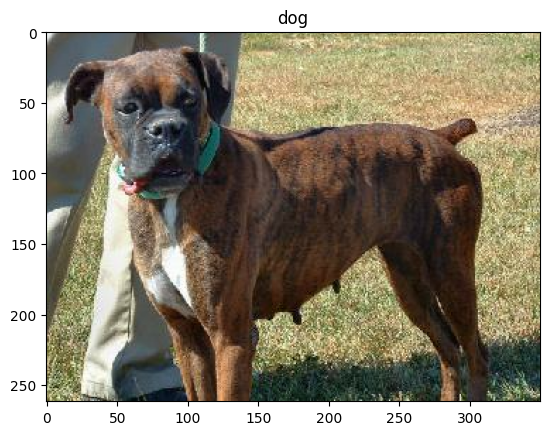

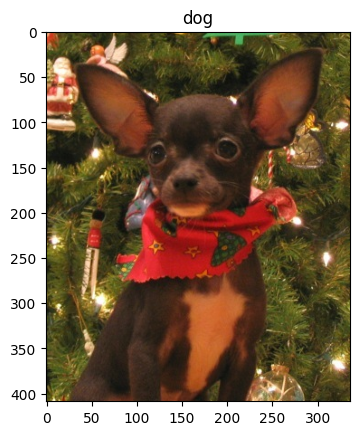

In [59]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

## 이미지 전처리

In [63]:
IMG_SIZE = 160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = image/127.5 - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [64]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [65]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [68]:
for image_batch, label_batch in train_batches.take(1):
  pass
image_batch.shape

TensorShape([32, 160, 160, 3])

## 모델링

### 참고모델 로딩
- "MobileNetV2"

In [71]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,     # 출력단 False
                                               weights="imagenet")

9406464/9406464 [==============================] - 1s 0us/step


In [72]:
# 이미지변환 : 160x160x3 -> 5x5x1280
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [73]:
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### 모델 구성

In [75]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # 채널마다 평균값 반환
feature_batch_average = global_average_layer(feature_batch)     # 이미지 1개당 1280개의 요소벡터로 변환
print(feature_batch_average.shape)

(32, 1280)


In [76]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [77]:
# 양수는 1, 음수는 0을 예측
# 예측범위 
prediction_batch

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-2.1381812 ],
       [-1.2704661 ],
       [-0.4380502 ],
       [-0.38014916],
       [-0.6325407 ],
       [-0.67827594],
       [-0.28133762],
       [-0.45742393],
       [-0.01221895],
       [ 0.7821598 ],
       [-1.5682523 ],
       [-0.50551605],
       [-0.84043556],
       [ 0.12125933],
       [-0.42881557],
       [-1.2728612 ],
       [ 1.4204981 ],
       [-0.37630153],
       [ 0.20974532],
       [-0.71559775],
       [-0.37571365],
       [-1.2341185 ],
       [-0.327626  ],
       [-1.1187284 ],
       [-3.2876973 ],
       [-0.89289856],
       [-0.8127973 ],
       [-0.9243393 ],
       [-1.4819041 ],
       [-0.4630156 ],
       [-1.2686617 ],
       [-1.1324968 ]], dtype=float32)>

In [81]:
model = tf.keras.Sequential([
    base_model,           # MobileNetV2
    global_average_layer, # 풀링층
    prediction_layer      # 출력(예측)층
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


## 모델 학습 및 평가

### 학습전 성능

In [82]:
initial_epochs = 10
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 3s 27ms/step - loss: 0.8211 - accuracy: 0.4984


### 모델학습

In [84]:
history = model.fit(train_batches,epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 28s 41ms/step - loss: 0.2249 - accuracy: 0.8947 - val_loss: 0.0910 - val_accuracy: 0.9695
Epoch 2/10
582/582 [==============================] - 23s 37ms/step - loss: 0.0775 - accuracy: 0.9717 - val_loss: 0.0641 - val_accuracy: 0.9776
Epoch 3/10
582/582 [==============================] - 27s 44ms/step - loss: 0.0615 - accuracy: 0.9768 - val_loss: 0.0557 - val_accuracy: 0.9789
Epoch 4/10
582/582 [==============================] - 28s 45ms/step - loss: 0.0548 - accuracy: 0.9800 - val_loss: 0.0516 - val_accuracy: 0.9815
Epoch 5/10
582/582 [==============================] - 28s 46ms/step - loss: 0.0508 - accuracy: 0.9812 - val_loss: 0.0492 - val_accuracy: 0.9824
Epoch 6/10
582/582 [==============================] - 27s 45ms/step - loss: 0.0482 - accuracy: 0.9819 - val_loss: 0.0477 - val_accuracy: 0.9819
Epoch 7/10
582/582 [==============================] - 26s 43ms/step - loss: 0.0463 - accuracy: 0.9822 - val_loss: 0.0465 - val_accuracy:

### 학습결과

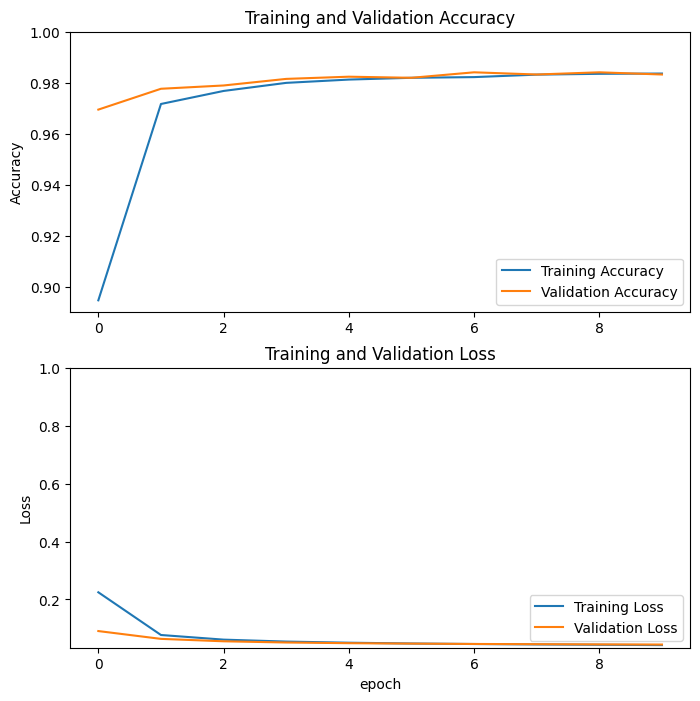

In [89]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Accuracy Plot
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

# Loss Plot
plt.subplot(212)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.ylabel("Loss")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

## 미세조정

In [90]:
# 전체 모델 trainable 설정
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [91]:
# 100번째 층부터 튜닝가능하게 설정
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [92]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [93]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches, epochs=total_epochs,
                         initial_epoch=history.epoch[-1],     # 앞의 epoch에서 이어서 학습
                         validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 38s 47ms/step - loss: 0.1303 - accuracy: 0.9526 - val_loss: 0.0599 - val_accuracy: 0.9837
Epoch 11/20
582/582 [==============================] - 25s 41ms/step - loss: 0.0685 - accuracy: 0.9731 - val_loss: 0.0507 - val_accuracy: 0.9832
Epoch 12/20
582/582 [==============================] - 25s 41ms/step - loss: 0.0500 - accuracy: 0.9798 - val_loss: 0.0476 - val_accuracy: 0.9819
Epoch 13/20
582/582 [==============================] - 27s 46ms/step - loss: 0.0408 - accuracy: 0.9835 - val_loss: 0.0453 - val_accuracy: 0.9815
Epoch 14/20
582/582 [==============================] - 29s 47ms/step - loss: 0.0319 - accuracy: 0.9883 - val_loss: 0.0496 - val_accuracy: 0.9798
Epoch 15/20
582/582 [==============================] - 28s 46ms/step - loss: 0.0239 - accuracy: 0.9918 - val_loss: 0.0480 - val_accuracy: 0.9815
Epoch 16/20
582/582 [==============================] - 26s 42ms/step - loss: 0.0209 - accuracy: 0.9926 - val_loss: 0.0450 - val_ac

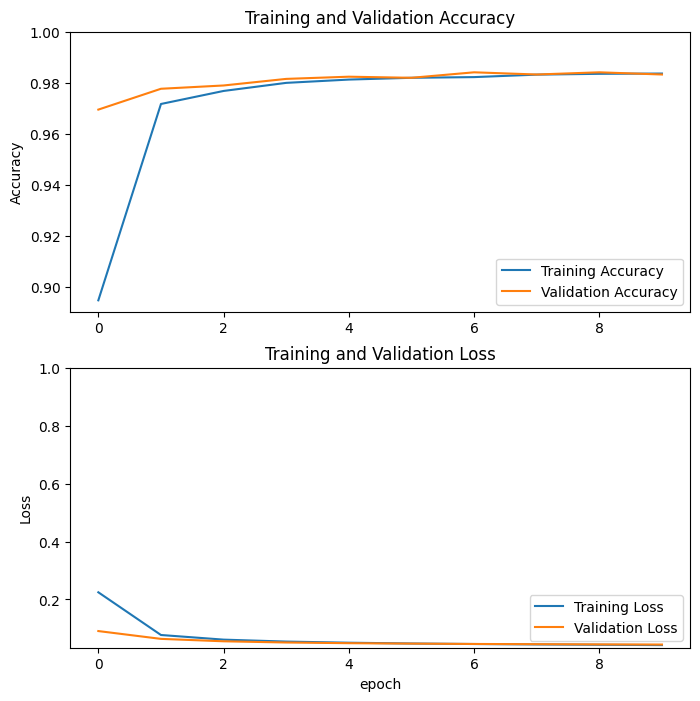

In [94]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Accuracy Plot
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

# Loss Plot
plt.subplot(212)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.ylabel("Loss")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

# 꽃이름 맞추기

In [95]:
import matplotlib.pyplot as plt
import tensorflow as tf

# !pip install -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

## 참고모델

### 참고모델 로딩

In [97]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
classifier_url = url

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

classifier.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


### 참고모델 평가

61306/61306 [==============================] - 0s 1us/step


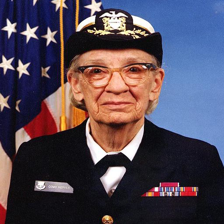

In [99]:
import numpy as np
import PIL.Image as Image

url = "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg"
grace_hopper = tf.keras.utils.get_file("image.jpg", url)
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [100]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [101]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 939ms/step


(1, 1001)

In [102]:
predicted_class = np.argmax(result[0], axis=-1) # 정답의 인덱스 반환
predicted_class

653

In [108]:
# 라벨을 받아서 정답여부 확인
url = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"
labels_path = tf.keras.utils.get_file("ImageNetLabels.txt", url)
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


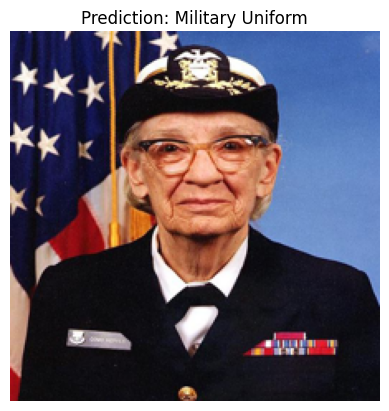

In [109]:
plt.imshow(grace_hopper)
plt.axis("off")
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## 꽃 데이터 가져오기

In [110]:
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_root = tf.keras.utils.get_file("flower_photos", url, untar=True) # 알집해제

228813984/228813984 [==============================] - 6s 0us/step


In [111]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


## image_batch


### image_batch 생성

In [112]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### batch_set 예측결과
- 좋은 성능은 아니다

In [113]:
result_batch = classifier.predict(image_batch)
result_batch.shape

1/1 [==============================] - 1s 687ms/step


(32, 1001)

In [114]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['pot', 'hummingbird', 'daisy', 'hummingbird', 'daisy', 'church',
       'daisy', 'orange', 'pot', 'pot', 'daisy', 'daisy', 'daisy',
       'daisy', 'vault', 'coral fungus', 'orange', 'mushroom', 'daisy',
       'strawberry', 'daisy', 'fly', 'cardoon', 'chime', 'picket fence',
       'bee', 'daisy', 'daisy', 'spider web', 'daisy', 'daisy',
       'hummingbird'], dtype='<U30')

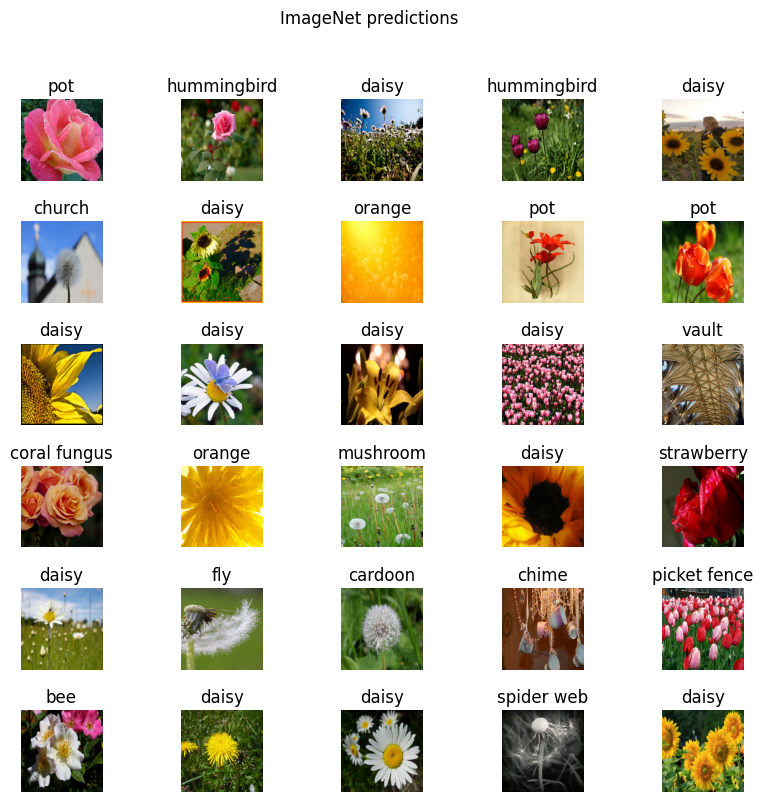

In [116]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis("off")
_ = plt.suptitle("ImageNet predictions")

## 전이학습
### 특징 추출기 ReLoad

In [125]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224, 224, 3))

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1001)


## 부분 모델링

In [126]:
feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation="softmax")
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 dense_7 (Dense)             (None, 5)                 5010      
                                                                 
Total params: 3,545,275
Trainable params: 5,010
Non-trainable params: 3,540,265
_________________________________________________________________


In [127]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [130]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## 모델학습

In [135]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs["loss"])
    self.batch_acc.append(logs["accuracy"])
    self.model.reset_metrics()

In [136]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2


<ipython-input-136-dd38f4e8ca03>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data, epochs=2,


115/115 [==============================] - 15s 126ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 2/2
115/115 [==============================] - 15s 131ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


## 학습결과

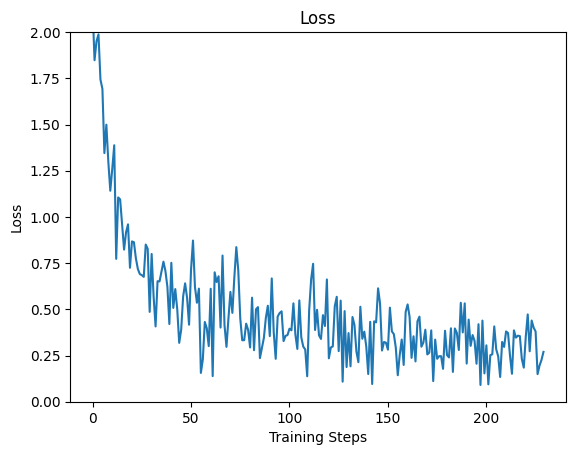

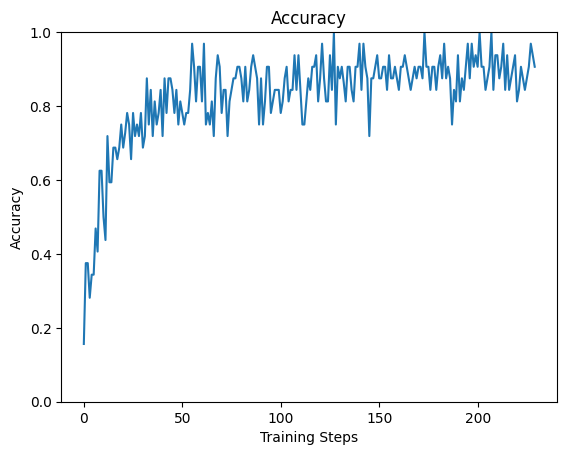

In [137]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.title("Loss")
plt.plot(batch_stats_callback.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.title("Accuracy")
plt.plot(batch_stats_callback.batch_acc)

## 예측 재시도

In [138]:
# 라벨 추가
class_names = sorted(image_data.class_indices.items(), key=lambda pair: pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [139]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

1/1 [==============================] - 0s 479ms/step


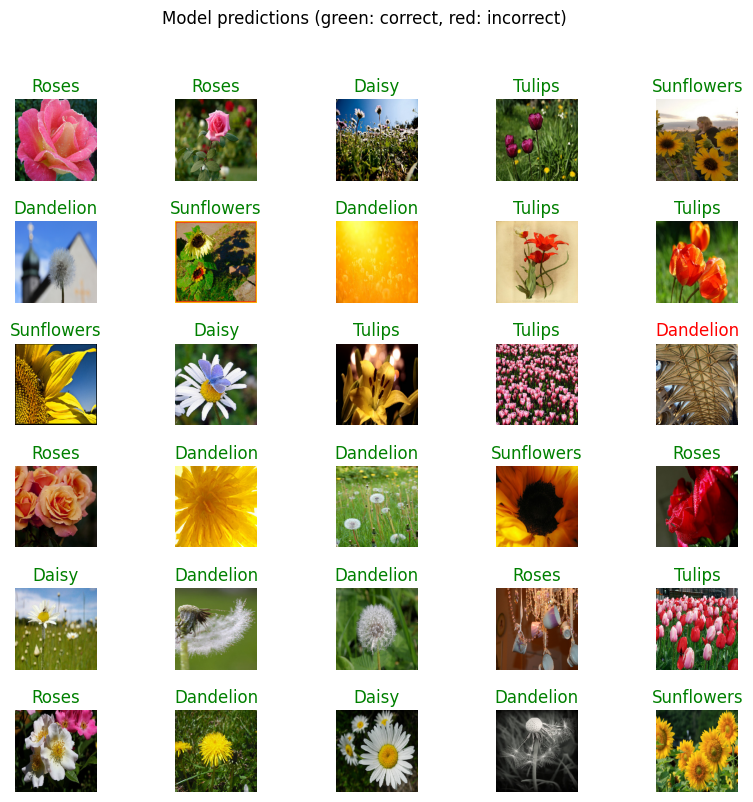

In [140]:
# 정답이면 녹색, 오답이면 적색
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis("off")
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Model Save

In [141]:
import time
t = time.time()

export_path = "./{}".format(int(t))
model.save(export_path, save_format="tf")

export_path

'./1682884596'

In [144]:
# 데이터를 읽고 다음과 같이 사용하면 됨
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

abs(reloaded_result_batch - result_batch).max()

1/1 [==============================] - 1s 501ms/step


0.0